In [172]:
import pandas as pd

# Define the data as a dictionary
# data = {
#     "ade": ["allergies", "HURT YOUR Liver", "AD", "focus", "died", "died", "tendon damage", "dreams", "tendon rupture",
#             "withdrawal", "emotional mess", "not remember", "memory lapse", "nap"],
#     "soc_code": [10021428, 10019805, 10037175, 10029205, 10018065, 10018065, 10022117, 10037175, 10022117, 10018065,
#                  10037175, 10029205, 10029205, 10029205]
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Display DataFrame
# print(df)


In [173]:
from google.colab import drive
import pandas as pd
import csv

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/smm4h2024/data/ADEnormalizationSOC.tsv'
# Read the CSV file into a DataFrame
data = pd.read_csv(data_path, sep='\t')
# data = pd. DataFrame(data)
# Display the DataFrame
# print(data.head)
# # print(data['ade'],data['soc_code'])
# data['soc_code'].value_counts()
data = data[data['soc_code'] != 0]

print(data.head)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<bound method NDFrame.head of                             ade  soc_code
0                     allergies  10021428
1               HURT YOUR Liver  10019805
2                            AD  10037175
3                         focus  10029205
4                          died  10018065
...                         ...       ...
1706                     orgasm  10037175
1707  never have another orgasm  10037175
1708                       coma  10029205
1709        gain so much weight  10022891
1710         increase my weight  10022891

[1710 rows x 2 columns]>


In [174]:
!pip install transformers
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

data.head()

,ade,soc_code
0,allergies,10021428
1,HURT YOUR Liver,10019805
2,AD,10037175
3,focus,10029205
4,died,10018065


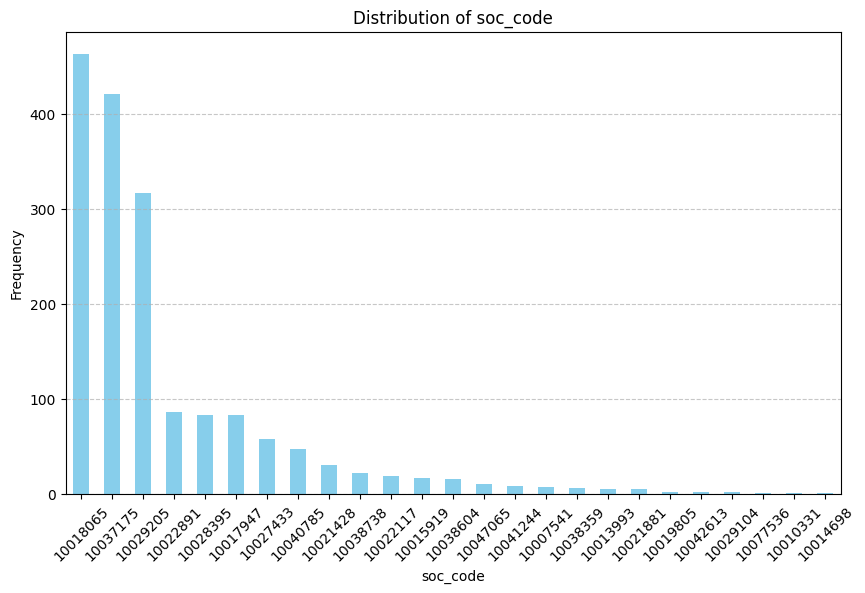

In [175]:
import matplotlib.pyplot as plt

#plot data distribution
# Plot soc_code distribution
plt.figure(figsize=(10, 6))
data['soc_code'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of soc_code')
plt.xlabel('soc_code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [176]:
data['soc_code'].value_counts()
df = data

In [177]:
import pandas as pd

# Get unique labels and their counts
label_counts = df['soc_code'].value_counts()

# Sort labels by counts
sorted_labels = label_counts.index.tolist()

# Create label dictionary with labels assigned from 1 to the number of unique labels
label_dict = {label: i for i, label in enumerate(sorted_labels, 0)}

# Print label dictionary
print(label_dict)


{10018065: 0, 10037175: 1, 10029205: 2, 10022891: 3, 10028395: 4, 10017947: 5, 10027433: 6, 10040785: 7, 10021428: 8, 10038738: 9, 10022117: 10, 10015919: 11, 10038604: 12, 10047065: 13, 10041244: 14, 10007541: 15, 10038359: 16, 10013993: 17, 10021881: 18, 10019805: 19, 10042613: 20, 10029104: 21, 10077536: 22, 10010331: 23, 10014698: 24}


In [ ]:
# possible_labels = df.soc_code.unique()

# label_dict = {}
# for index, possible_label in enumerate(possible_labels):
#     label_dict[possible_label] = index

# label_dict


In [178]:
label_df = pd.DataFrame.from_dict(label_dict, orient='index', columns=['Label'])

# Reset index to make the index a regular column
label_df.reset_index(inplace=True)

# Rename columns
label_df.columns = ['SOC Code', 'Label']

# Sort DataFrame by label
label_df = label_df.sort_values(by='Label')

# Print the DataFrame
print(label_df)

    SOC Code  Label
0   10018065      0
1   10037175      1
2   10029205      2
3   10022891      3
4   10028395      4
5   10017947      5
6   10027433      6
7   10040785      7
8   10021428      8
9   10038738      9
10  10022117     10
11  10015919     11
12  10038604     12
13  10047065     13
14  10041244     14
15  10007541     15
16  10038359     16
17  10013993     17
18  10021881     18
19  10019805     19
20  10042613     20
21  10029104     21
22  10077536     22
23  10010331     23
24  10014698     24


In [179]:
df['label'] = df.soc_code.replace(label_dict)

In [180]:
from sklearn.model_selection import train_test_split
import numpy as np

def custom_train_test_split(X, y, test_size=0.15, random_state=None):
    classes, counts = np.unique(y, return_counts=True)
    min_class_count = min(counts)

    # Find classes with only one or two instances
    single_or_double_instance_classes = classes[np.logical_or(counts == 1, counts == 2)]

    # Remove instances of single-instance or two-instance classes
    X_filtered = X[~np.isin(y, single_or_double_instance_classes)]
    y_filtered = y[~np.isin(y, single_or_double_instance_classes)]

    if len(y_filtered) < 2:
        raise ValueError("No classes have more than two instances after filtering.")

    # Perform stratified split on the filtered dataset
    X_train, X_val, y_train, y_val = train_test_split(X_filtered, y_filtered, test_size=test_size, random_state=random_state, stratify=y_filtered)

    # Randomly assign instances of single-instance classes to training or testing sets
    for class_label in single_or_double_instance_classes:
        class_indices = np.where(y == class_label)[0]
        np.random.shuffle(class_indices)

        if len(class_indices) <= 2:
            # Only one instance, randomly assign to training or testing set
            if np.random.rand() < test_size:
                X_val = np.concatenate((X_val, X[class_indices]))
                y_val = np.concatenate((y_val, y[class_indices]))
            else:
                X_train = np.concatenate((X_train, X[class_indices]))
                y_train = np.concatenate((y_train, y[class_indices]))

    return X_train, X_val, y_train, y_val

# Usage:
X_train, X_val, y_train, y_val = custom_train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=42)


In [181]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['soc_code', 'label', 'data_type']).count()

ade
soc_code label data_type     
10007541 15    train        6
               val          1
10010331 23    val          1
10013993 17    train        4
               val          1
10014698 24    train        1
10015919 11    train       14
               val          3
10017947 5     train       66
               val         17
10018065 0     train      370
               val         93
10019805 19    val          2
10021428 8     train       24
               val          6
10021881 18    train        4
               val          1
10022117 10    train       15
               val          4
10022891 3     train       69
               val         17
10027433 6     train       46
               val         12
10028395 4     train       66
               val         17
10029104 21    train        2
10029205 2     train      253
               val         63
10037175 1     train      337
               val         84
10038359 16    train        5
               val          1
10038604 12    train       12
               val          3
10038738 9     train       18
               val          4
10040785 7     train       37
               val         10
10041244 14    train        6
               val          2
10042613 20    val          2
10047065 13    train        8
               val          2
10077536 22    train        1

In [182]:
result = df.groupby(['soc_code', 'label', 'data_type']).size().reset_index(name='count')
result_sorted = result.sort_values(by='label')
print(result_sorted)

    soc_code  label data_type  count
10  10018065      0     train    370
11  10018065      0       val     93
29  10037175      1       val     84
28  10037175      1     train    337
27  10029205      2       val     63
26  10029205      2     train    253
20  10022891      3       val     17
19  10022891      3     train     69
24  10028395      4       val     17
23  10028395      4     train     66
8   10017947      5     train     66
9   10017947      5       val     17
22  10027433      6       val     12
21  10027433      6     train     46
36  10040785      7     train     37
37  10040785      7       val     10
14  10021428      8       val      6
13  10021428      8     train     24
34  10038738      9     train     18
35  10038738      9       val      4
17  10022117     10     train     15
18  10022117     10       val      4
7   10015919     11       val      3
6   10015919     11     train     14
33  10038604     12       val      3
32  10038604     12     train     12
4

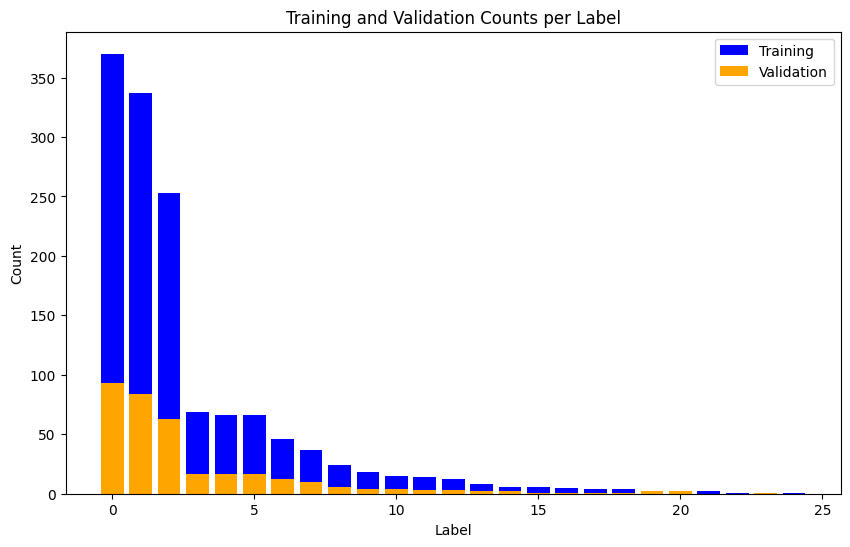

In [184]:
import matplotlib.pyplot as plt

# Group by soc_code, label, and data_type
grouped = df.groupby(['soc_code', 'label', 'data_type']).size().reset_index(name='count')

# Filter data for training and validation
train_counts = grouped[grouped['data_type'] == 'train']
val_counts = grouped[grouped['data_type'] == 'val']

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(train_counts['label'], train_counts['count'], color='blue', label='Training')
plt.bar(val_counts['label'], val_counts['count'], color='orange', label='Validation')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training and Validation Counts per Label')
plt.legend()
plt.show()


In [185]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].ade.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].ade.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In t

In [186]:
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

In [196]:
#data loader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [197]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [198]:
#evaluation
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [199]:
# Assuming device is cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move input tensors to the same device as the model
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

inputs = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "labels": labels
}


In [200]:
print(f"Device used: {device}")


Device used: cuda


In [201]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/455 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('./finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class: 10021428
Accuracy: 4/5

Class: 10037175
Accuracy: 49/63

Class: 10029205
Accuracy: 29/48

Class: 10018065
Accuracy: 56/70

Class: 10022117
Accuracy: 0/3

Class: 10027433
Accuracy: 1/9

Class: 10028395
Accuracy: 6/12

Class: 10040785
Accuracy: 4/7

Class: 10015919
Accuracy: 0/3

Class: 10022891
Accuracy: 8/13

Class: 10017947
Accuracy: 6/12

Class: 10038604
Accuracy: 0/2

Class: 10038738
Accuracy: 0/3

Class: 10021881
Accuracy: 0/1

Class: 10047065
Accuracy: 0/1

Class: 10038359
Accuracy: 0/1

Class: 10041244
Accuracy: 0/1

Class: 10007541
Accuracy: 0/1

Class: 10013993
Accuracy: 0/1



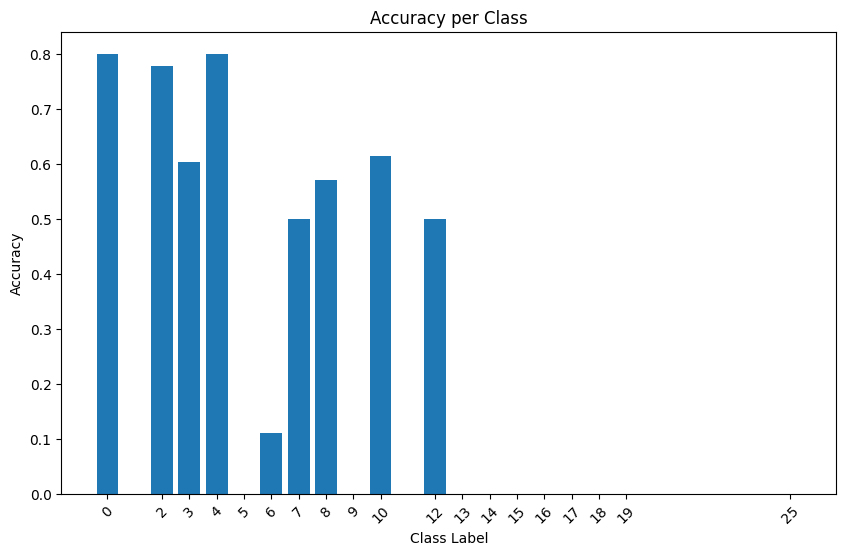

In [ ]:
import matplotlib.pyplot as plt

def accuracy_per_class(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()
    accuracy_dict = {}
    for label in np.unique(labels_flat):
        y_preds = pred_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy_dict[label] = np.sum(y_preds == y_true) / len(y_true)
    return accuracy_dict

accuracy_dict = accuracy_per_class(predictions, true_vals)

plt.figure(figsize=(10, 6))
plt.bar(accuracy_dict.keys(), accuracy_dict.values())
plt.xlabel('Class Label')
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.xticks(rotation=45)

# Show class labels instead of class indices
plt.xticks(list(accuracy_dict.keys()), list(accuracy_dict.keys()))

plt.show()


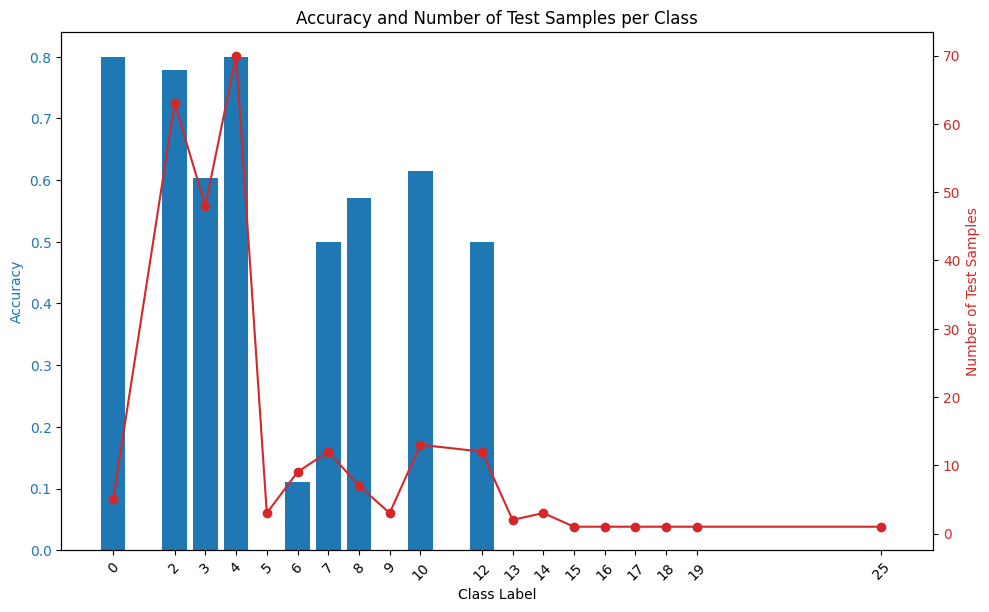

In [ ]:
import matplotlib.pyplot as plt

def accuracy_per_class(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()
    accuracy_dict = {}
    count_dict = {}
    for label in np.unique(labels_flat):
        y_preds = pred_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy_dict[label] = np.sum(y_preds == y_true) / len(y_true)
        count_dict[label] = len(y_true)
    return accuracy_dict, count_dict

accuracy_dict, count_dict = accuracy_per_class(predictions, true_vals)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('Class Label')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(accuracy_dict.keys(), accuracy_dict.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Show class labels instead of class indices
ax1.set_xticks(list(accuracy_dict.keys()))
ax1.set_xticklabels(list(accuracy_dict.keys()), rotation=45)

# Plot number of samples
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Test Samples', color=color)
ax2.plot(count_dict.keys(), count_dict.values(), color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Accuracy and Number of Test Samples per Class')
plt.show()


In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['soc_code'])

# Tokenize text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(data['ade'], padding=True, truncation=True)

# Convert to PyTorch tensors
input_ids = torch.tensor(encodings['input_ids'])
attention_mask = torch.tensor(encodings['attention_mask'])
labels = torch.tensor(data['label'])

# Split the data into training and testing sets
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)

In [ ]:
!pip install transformers accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 28.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
# Define the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',  # Specify the output directory
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    report_to="none"  # Disable output to prevent cluttering
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels),
    eval_dataset=torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels),
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`